In [25]:
from scipy.spatial import distance as dist
from imutils import face_utils
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import imutils
import numpy as np
import time
import dlib
import cv2
import os

In [26]:
# get the base directory
BASE_PATH = os.getcwd()

In [27]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear

In [28]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# grab the indexes of the facial landmarks for the left and
# right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

[INFO] loading facial landmark predictor...


In [29]:
def sleep_detect(FILENAME, eye_ar_thresh, eye_ar_consec_frames):
    # start the video stream thread
	print(f'[INFO] processing video {FILENAME}')
	vs = cv2.VideoCapture(FILENAME)

	if (vs.isOpened() == False):
		print("Error opening video file")

	time.sleep(1.0)

	# initialize the frame counters
	counter = 0
	frames_slept = 0
	frames_awake = 0

	# loop over frames from the video stream
	while True:
		# grab the frame from the threaded video file stream
		ret, frame = vs.read()
		# if no frames has been grabbed break
		if ret == False:
			break
		# Resize frame
		frame = imutils.resize(frame, width=480)
		# convert frame to grayscale channels
		gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
		# detect faces in the grayscale frame
		rects = detector(gray, 0)

		# loop over the face detections
		for rect in rects:
			# determine the facial landmarks for the face region, then
			# convert the facial landmark (x, y)-coordinates to a NumPy
			# array
			shape = predictor(gray, rect)
			shape = face_utils.shape_to_np(shape)
			# extract the left and right eye coordinates, then use the
			# coordinates to compute the eye aspect ratio for both eyes
			leftEye = shape[lStart:lEnd]
			rightEye = shape[rStart:rEnd]
			leftEAR = eye_aspect_ratio(leftEye)
			rightEAR = eye_aspect_ratio(rightEye)
			# average the eye aspect ratio together for both eyes
			ear = (leftEAR + rightEAR) / 2.0

			# compute the convex hull for the left and right eye, then
			# visualize each of the eyes
			leftEyeHull = cv2.convexHull(leftEye)
			rightEyeHull = cv2.convexHull(rightEye)
			cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
			cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

			# check to see if the eye aspect ratio is below the blink
			# threshold, and if so, increment the blink frame counter
			if ear < eye_ar_thresh:
				counter += 1
			else:
				# reset the eye frame counter
				counter = 0

			if counter >= eye_ar_consec_frames:
				frames_slept += 1
			else: 
				frames_awake += 1

	vs.release()			
	return frames_slept > frames_awake

In [30]:
EXAMPLES_PATH = os.path.join(BASE_PATH, 'sleep_dataset')
AWAKE_PATH = os.path.join(EXAMPLES_PATH, 'awake')
SLEEP_PATH = os.path.join(EXAMPLES_PATH, 'sleep')

[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\2.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\3.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\4.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\5.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\6.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\7.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\8.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\9.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\2.mp4
[INFO] processing vid

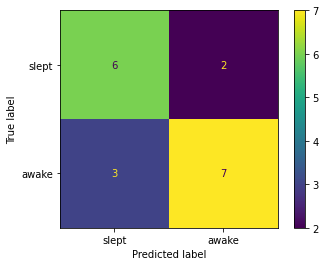

accuracy = 0.7222222222222222
precision = 0.75
recall = 0.6666666666666666
f1 = 0.7058823529411765


In [32]:
# define two constants, one for the eye aspect ratio to indicate
# closed eye and then a second constant for the number of consecutive
# frames the eye must be below the threshold 
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 30

tp = fp = fn = tn = 0

for file in os.listdir(AWAKE_PATH):
    path = os.path.join(AWAKE_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == False:
        tn += 1
    else:
        fp += 1
for file in os.listdir(SLEEP_PATH):
    path = os.path.join(SLEEP_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == True:
        tp += 1
    else:
        fn += 1

cm = np.array(
    [
        [tp, fp],
        [fn, tn]
    ]
)

labels = ["slept", "awake"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels)
                               
disp.plot()
plt.show()

acc = (tp + tn) / (tp + fn + tn + fp)
pre = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * pre * rec) / (pre + rec)

print(f'accuracy = {acc}')
print(f'precision = {pre}')
print(f'recall = {rec}')
print(f'f1 = {f1}')


[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\2.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\3.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\4.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\5.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\6.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\7.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\8.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\9.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\2.mp4
[INFO] processing vid

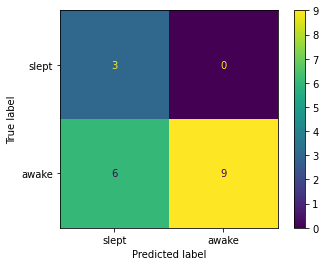

accuracy = 0.6666666666666666
precision = 1.0
recall = 0.3333333333333333
f1 = 0.5


In [33]:
EYE_AR_THRESH = 0.2
EYE_AR_CONSEC_FRAMES = 30

tp = fp = fn = tn = 0

for file in os.listdir(AWAKE_PATH):
    path = os.path.join(AWAKE_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == False:
        tn += 1
    else:
        fp += 1
for file in os.listdir(SLEEP_PATH):
    path = os.path.join(SLEEP_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == True:
        tp += 1
    else:
        fn += 1

cm = np.array(
    [
        [tp, fp],
        [fn, tn]
    ]
)

labels = ["slept", "awake"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels)
                               
disp.plot()
plt.show()

acc = (tp + tn) / (tp + fn + tn + fp)
pre = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * pre * rec) / (pre + rec)

print(f'accuracy = {acc}')
print(f'precision = {pre}')
print(f'recall = {rec}')
print(f'f1 = {f1}')

[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\2.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\3.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\4.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\5.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\6.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\7.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\8.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\awake\9.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\1.mp4
[INFO] processing video c:\Users\lm555\Desktop\sleep_detection\sleep_dataset\sleep\2.mp4
[INFO] processing vid

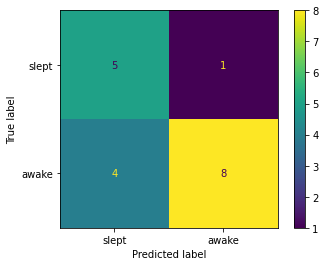

accuracy = 0.7222222222222222
precision = 0.8333333333333334
recall = 0.5555555555555556
f1 = 0.6666666666666667


In [36]:
EYE_AR_THRESH = 0.25
EYE_AR_CONSEC_FRAMES = 30

tp = fp = fn = tn = 0

for file in os.listdir(AWAKE_PATH):
    path = os.path.join(AWAKE_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == False:
        tn += 1
    else:
        fp += 1
for file in os.listdir(SLEEP_PATH):
    path = os.path.join(SLEEP_PATH, file)
    if sleep_detect(path, EYE_AR_THRESH, EYE_AR_CONSEC_FRAMES) == True:
        tp += 1
    else:
        fn += 1

cm = np.array(
    [
        [tp, fp],
        [fn, tn]
    ]
)

labels = ["slept", "awake"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels)
                               
disp.plot()
plt.show()

acc = (tp + tn) / (tp + fn + tn + fp)
pre = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * pre * rec) / (pre + rec)

print(f'accuracy = {acc}')
print(f'precision = {pre}')
print(f'recall = {rec}')
print(f'f1 = {f1}')